# 同花顺行业概念信息

In [1]:

import pandas as pd

fpath = r'../../JohnsonUtil\wencai\同花顺板块行业.xls'
thsgn = pd.read_excel(fpath)
thsgn = thsgn.set_index('股票代码')

## 查询信息

In [2]:
thsgn[:1]
thsgn.columns
thsgn.loc['002670.SZ']

股票简称                                                                 国盛金控
现价(元)                                                                9.46
涨跌幅(%)                                                               0.96
主营产品名称                  电源输入组件||电热电器电源输入组件||冰洗电器电源输入组件||空调电源输入组件||空调连接...
所属概念                    深股通;区块链;转融券标的;富时罗素概念;富时罗素概念股;消费金融;标普道琼斯A股;融资融券...
所属同花顺行业                                                       非银金融-证券-证券Ⅲ
经营范围                    控股公司服务，股权投资，投资管理与咨询；金融信息服务；科技中介服务，技术推广服务，软件开发，...
公司网站                                                       www.gsfins.com
所属概念数量(个)                                                              11
a股流通市值 (元)2023.01.31                                          15356897000
Name: 002670.SZ, dtype: object

# Debug开启

In [3]:

# Delete Jupyter notebook root logger handler
# Set Debug
import logging
import sys

# %matplotlib inline
%matplotlib widget
# stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# # # reload(sys)
# # # sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# stdout = sys.stdout
# sys.path.append('../')
# import JSONData.tdx_data_Day as tdd
# sys.stdout = stdout


mylogger = logging.getLogger()
if len(mylogger.handlers) > 0:
    for ix in mylogger.handlers:
        print("handlers:%s std:%s" % (ix.stream, sys.stdout))
else:
    print("nb not handlers")
#     mylogger.propagate = False
mylogger.setLevel(logging.ERROR)
# mylogger.setLevel(logging.DEBUG)

print("nb:", sys.stderr)
# # Create logger as usual
import nest_asyncio

nest_asyncio.apply()

nb not handlers
nb: <ipykernel.iostream.OutStream object at 0x0000020A95302370>


# TDX多日数据分析

## 定义 TDX-Path

In [4]:
# encoding:utf-8
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last_expr"

import sys

import pandas as pd
from pandas import HDFStore

stdi, stdo, stde = sys.stdin, sys.stdout, sys.stderr
# print(stdi, stdo, stde)
# reload(sys)
# sys.setdefaultencoding('utf-8')
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# print(sys.stdout,sys.stderr,sys.stderr)

# print(stdi, stdo, stde)

# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

In [5]:
sys.path.append("../../")
import os

import JSONData.tdx_data_Day as tdd
# import win_unicode_console
from JohnsonUtil import commonTips as cct
from JSONData import sina_data

os.environ['NUMEXPR_MAX_THREADS'] = '12'

# import nest_asyncio
# nest_asyncio.apply()
# 查阅资料后发现，发现使用 jupyter notebook 环境，其连接着 IPython 内核，而 IPython 内核本身在事件循环上运行，而 asyncio 不允许嵌套其事件​​循环，因此会出现如上图的错误信息。
# nest_asyncio 作为异步操作的补丁而存在，具体内容请参考
# win_unicode_console.disable()
tdx_path = "G:\\tdx_last_df.h5"
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
sina_d_path = "G:\\sina_data.h5"
sina_dd_path = "G:\\get_sina_all_dd.h5"
# print(stdi, stdo, stde)
sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde

# # 显示所有列
pd.set_option("display.max_columns", None)
# # 显示所有行
# pd.set_option('display.max_rows', None)
# # 设置 value 的显示长度为 100，默认为 50
# pd.set_option('max_colwidth',100)
# pd.set_option?
# df.columns.tolist()

In [6]:
cct.code_to_symbol_ths('000002')

'000002.SZ'

### 功能定义

In [7]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df


def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df


def write_code_to_blk(codew, blk='090'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))


def show_tdx_data(df, codelist=None, market_value='3', col=None):

    columns_ = [
        "name", "category", "close", "percent", 'topR', "lastp1d", "ma5dcum",
        "ma20d", "fib", "fibl", "ra", "ral", "df2", "per1d", "hmax", "lmin",
        "per%sd" % (market_value),
        "perc%sd" % (market_value)]
    if col is not None:
        columns_.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[columns_]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, columns_]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], columns_]
    return temp


def compute_perd_value(df, market_value=3, col="per"):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col))
                & (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df


from collections import Counter, OrderedDict


def counterCategory(df):
    top5 = dict()
    if len(df) > 0:
        categoryl = df.category[:20].tolist()
        dicSort = []
        for i in categoryl:
            if isinstance(i, str):
                # dicSort.extend([ co.decode('utf8') for co in i.split(';')])
                dicSort.extend(i.split(';'))
                # cate_list = i.split(';')
                # for co in cate_list:
                #     dicSort.append(to_str(co))
        topSort = Counter(dicSort)
        top5 = OrderedDict(topSort.most_common(5))
        # for i in top5.keys():
        # print(i, top5[i]),
        # print('')
    return top5


def get_runtime_percent(df, perd=None):
    if "percent" not in df.columns and "lastp1d" in df.columns:
        # print('init percent')
        df = df.fillna(0)
        df['percent'] = list(
            map(
                lambda x, y, z: round((x - y) / y * 100, 1)
                if x != y else round((x - z) / z * 100, 1),
                df.close, df.lastp1d, df.lastp2d))
        # df['percent'] = df.apply(lambda x: round((x.close - x.lastp1d) /(x.lastp1d) * 100, 1),axis=1)
    # else:
    #     print('Percent in columns')
    if not perd is None:
        df[perd] = list(map(lambda x, y: round((x + y), 1)
                            if int(y) > 0 else 0, df.perd, df.percent))
    return df


def get_realtime_ratio(df, market='all'):
    if 'ratio' in df.columns:
        df.drop('ratio', axis=1, inplace=True)
    ratio_df = tdd.getSinaJsondf(market)
    df = cct.combine_dataFrame(
        df, ratio_df.ratio, col=None, compare=None, append=False, clean=False)
    return df


def get_ths_info(code):
    code = cct.code_to_symbol_ths(code)
    return thsgn.loc[code]

### 还原Cell输出信息

In [8]:
# sys.stdin, sys.stdout, sys.stderr = stdi, stdo, stde
# print(stdi, stdo, stde)

## 初始化 hdf5的tdx数据

In [9]:

market_value = "3"
df = readHdf5(tdx_path)
df = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
df = compute_perd_value(df, market_value, "perc")
df = compute_perd_value(df, market_value, "per")

df = get_realtime_ratio(df)
# df=get_runtime_percent(df)

df = get_runtime_percent(df, "per%sd" % (market_value))

# filter 科创
df = clean_688(df)

df.shape
df[-1:].percent
df[~(df.last6vol > 0)][:10].last6vol
df.ratio[-2:]

['/low_d_60_y_all', '/low_w_180_y_all']


(4447, 119)

code
600320    1.2
Name: percent, dtype: float64

Series([], Name: last6vol, dtype: float64)

code
002459    0.0
600320    0.1
Name: ratio, dtype: float64

## 个股数据查看

In [10]:
df.ma203d[:1]
# df.loc['003042'].loc[["category", "close"]]

code
999999    3192.95
Name: ma203d, dtype: float64

In [11]:
show_tdx_data(df.loc['003042'])
get_ths_info('003042')

Count:1


name                  中农联合
category    新股与次新股 ;核准制次新股
close                 28.5
percent               -4.0
topR                     0
lastp1d              29.68
ma5dcum               25.8
ma20d                26.59
fib                     28
fibl                     9
ra                     0.0
ral                  -22.3
df2                      4
per1d                  2.4
hmax                  35.0
lmin                 24.68
per3d                  0.0
perc3d                 3.2
Name: 003042, dtype: object

股票简称                                                                 中农联合
现价(元)                                                               26.24
涨跌幅(%)                                                               0.92
主营产品名称                  吡虫啉||啶虫脒||烯啶虫胺||哒螨灵||低毒农药原药及其中间体||杀虫剂||杀菌剂||除草...
所属概念                                                  草甘膦;乡村振兴;中俄贸易概念;供销社
所属同花顺行业                                                      基础化工-化学制品-农药
经营范围                    生物、化学农药、化工产品及仪器仪表的技术开发、技术转让、技术咨询服务；农药（不含化学危险品）...
公司网站                                                       www.sdznlh.com
所属概念数量(个)                                                               4
a股流通市值 (元)2023.01.31                                           1787252200
Name: 003042.SZ, dtype: object

In [12]:
# df[(df.close > df.ma20d * 0.99) & (df.close < df.ma20d * 1.05)]

def filter_ma_range_df(df, ma='20', days='3'):
    dd = []
    for da in range(int(days), 0, -1):
        # print(da, ma)
        # df1 = df[ (df['lastp%sd'%(da)] > df['ma%s%sd'%(ma,da)]) & (df['lastp%sd'%(days)] < df['ma%s%sd'%(ma,da)] * 1.1)]
        df1 = df[(df['lastp%sd' % (da)] > df['ma%s%sd' % (ma, da)] * 0.99)]
        if da == days:
            dd = df1.index.tolist()
        else:
            dd = [x for x in dd if x in df1.index]

    return [x for x in set(dd)]


def get_union_list(maind, subd):
    # 筛选Main存在后切在新Sub出现
    return [x for x in maind if x in subd]

### 新农联合筛选

In [13]:
code_fs = '003042'
# show_tdx_data(df.loc['003042'])
# get_ths_info('003042')

df_f_t = df[(df.fib < 30) & (df.fibl > 6) & (df.df2 > 2) & (df.ral < -15) &
            (df.close >= df.ma5dcum) & (df.perc3d > 1.1) & (df.lastv1d > df.lastv2d) & (df.close > df.ma5d) ]

df_f_t.shape
df_f_t.loc[code_fs][:1]
show_tdx_data(df_f_t)[:5]


(16, 119)

lopen    25.3
Name: 003042, dtype: object

Count:16 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
600557,康缘药业,炭疽;医疗改革;独家医药品种,21.94,-1.0,0,22.16,21.7,21.13,24,9,3.0,-19.4,7,2.6,26.04,20.94,0.0,2.9
301396,宏景科技,0,44.50,-5.9,0,47.30,39.2,38.23,21,9,0.0,-21.2,7,6.7,50.01,35.76,0.0,3.2
300535,达威股份,高送转,14.26,-0.1,0,14.27,13.6,13.46,22,9,0.0,-16.1,3,1.6,16.85,13.10,0.0,3.2
301052,果麦文化,融资融券 ;转融券标的 ;新股,25.71,-2.8,1,26.44,24.1,23.78,22,9,0.0,-22.2,3,2.7,31.20,22.70,0.0,3.1
300820,英杰电气,新股与次新股 ;非科创次新股,94.74,-2.8,1,97.43,83.8,82.10,25,9,0.0,-18.7,6,6.3,116.66,73.02,0.0,3.1


#### 写入069

In [14]:
# write_code_to_blk(df_f_t.index, '069')

In [15]:
df_ma26d = filter_ma_range_df(df, ma=20, days=5)
# 连续3日在生命线上
# df_ma26d = df[(df.fibl > 1) & (df.ra > 5)]
len(df_ma26d)
df_ma5d = filter_ma_range_df(df, ma=5, days=5)

# 连续3日在生命线上
len(df_ma5d)
df_x = get_union_list(df_ma26d, df_ma5d)
df_5dx_20d = get_union_list(df_x, df[df.ma5d < df.ma20d].index)

show_tdx_data(df.loc[df_5dx_20d])

3704

2803

Count:9 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
601398,工商银行,MSCI概念;优先股概念;外汇,4.29,-0.2,0,4.29,4.3,4.32,60,1,3.0,-2.1,0,-0.2,4.36,4.29,0.0,0.0
601169,北京银行,MSCI概念;村镇银行;融资融,4.24,0.2,0,4.23,4.3,4.26,60,8,0.0,-3.9,0,-0.2,4.39,4.22,0.0,0.9
601366,利群股份,互联网平台;腾讯概念,5.98,-0.3,0,6.00,6.0,6.04,57,6,0.0,-5.2,0,0.2,6.26,5.90,0.0,3.0
601825,沪农商行,新股与次新股 ;核准制次新股,5.88,-0.2,0,5.89,5.9,5.93,60,1,3.0,-3.1,0,-0.3,6.01,5.88,0.0,0.0
001896,豫能控股,地方国资改革;电力改革;新能源,5.15,0.2,0,5.14,5.1,5.17,26,8,0.0,-13.3,1,0.2,5.73,5.01,0.0,3.1
603992,松霖科技,新股与次新股 ;智能家居,16.48,1.9,0,16.18,15.8,16.10,60,8,0.0,-7.8,5,0.7,17.08,15.20,2.6,3.1
000719,中原传媒,有声读物;地方国资改革;融资融,8.40,0.2,0,8.38,8.3,8.45,60,8,0.0,-20.0,3,-0.5,9.52,8.05,0.0,3.0
601939,建设银行,央视财经50;优先股概念;MS,5.60,0.2,0,5.59,5.6,5.63,59,1,0.0,-1.9,0,-0.2,5.68,5.58,0.0,0.0
603227,雪峰科技,新疆振兴,9.22,-1.4,-1,9.35,9.2,9.25,26,8,0.0,-8.6,4,1.0,10.19,8.42,0.0,3.2


In [16]:
df.loc[["603068", '601377', '000725'],
       ["date", "name", "category", "percent", "close", "lastp1d", "ma5d",
        "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
        "ra", "ral", "vcall", "vcra", "vchange", "lvol", 'lv', 'lowvol',
        'last6vol', 'per%sd' % (market_value),
        'perc%sd' % (market_value),
        'perc4d']][: 3]

,date,name,category,percent,close,lastp1d,ma5d,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,vcall,vcra,vchange,lvol,lv,lowvol,last6vol,per3d,perc3d,perc4d
code,,,,,,,,,,,,,,,,,,,,,,,,,,,
603068,2022-11-10,博通集成,新股与次新股,0.0,32.23,32.22,32.09,31.4,30.49,55,5,7,-1.3,34.56,28.86,0.0,-10.2,430.4,2.0,-30.4,3110800.0,1506600.0,2213052.0,3110800.0,0.0,3.0,1.1
601377,2022-11-09,兴业证券,参股新三板;MSCI概念;融资,0.3,6.57,6.55,6.79,6.8,6.48,57,1,8,-2.2,6.73,6.64,4.0,-7.7,373.1,4.0,3.3,102669569.0,21547268.0,29337625.0,88737321.0,0.0,-0.2,1.0
000725,2022-12-29,京东方Ａ,国开行;物联网;OLED,1.0,4.07,4.03,4.02,4.0,3.83,22,9,4,0.5,3.87,3.86,2.0,-2.4,165.0,3.0,7.2,355162498.0,90156798.0,146636206.0,303765163.0,1.5,3.0,1.1


In [17]:

sort_key2 = "per%sd" % (market_value)
df = df.sort_values(
    by=["perc%sd" % (market_value), sort_key2, "fib"], ascending=[0, 0, 1]
)
show_tdx_data(df)[: 5]

show_tdx_data(df)[-5:]
# df = df.sort_values(by=['perc%sd'%(market_value), 'per%sd'%(market_value),'fib'],ascending=[0,0,1])

Count:4447 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
300114,中航电测,军民融合;央企国资改革;仪电仪,21.95,20.0,3,18.29,11.1,11.14,16,5,0.0,20.0,3,10.0,18.29,9.98,30.0,3.3
002362,汉王科技,虹膜识别;指纹技术;电子纸,32.63,10.0,6,29.66,19.1,18.85,48,9,0.0,10.0,15,10.0,21.27,16.25,20.0,3.3
002574,明牌珠宝,在线教育;奢侈品;租售同权,7.14,7.5,1,6.64,5.8,5.92,45,8,0.0,-11.3,6,10.0,6.89,5.63,17.5,3.3
301159,三维天地,融资融券 ;转融券标的 ;国产,36.40,8.8,0,33.45,29.7,29.35,21,9,0.0,-7.1,8,3.7,34.57,27.96,12.5,3.3
001223,欧克科技,0,106.93,4.5,1,102.30,80.9,78.25,25,5,0.0,3.3,15,6.4,79.72,74.48,10.9,3.3


Count:4447 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
002781,*ST奇信,建筑节能;物联网,4.26,-4.9,-7,4.48,5.9,6.09,2,1,10.0,-51.9,0,-5.1,8.93,4.72,0.0,-3.3
002089,*ST新海,云服务;军民融合;华为概念,1.28,-5.2,-9,1.35,1.8,1.94,2,1,10.0,-49.2,0,-4.9,2.56,1.42,0.0,-3.3
600781,*ST辅仁,生物医药;阿糖胞苷;中医药,1.52,-5.0,-5,1.60,2.0,2.02,2,1,7.0,-43.7,1,-4.8,2.77,1.68,0.0,-3.3
600311,*ST荣华,兰新白试验区;淀粉;白银,0.89,-14.4,-3,1.04,1.2,1.18,18,1,3.0,-35.4,0,-4.6,1.60,1.09,0.0,-3.3
600146,退市环球,基因测序;她经济;互联网金融,0.22,-91.0,-7,2.44,3.1,3.31,45,1,10.0,-39.3,26,-5.1,3.92,2.57,0.0,-3.3


## filter 20D 涨幅榜 

In [18]:
# df = df[(df['close'] > df['ma20d'] * 0.98) & (df['close'] < df['ma20d'] * 1.03)]
f20df = df[(df['close'] > df['ma20d'] * 0.98)
           & (df['df2'] > 0) & (df['lastp1d'] > df['ma5d']) & (df['lasth1d'] >= df['lasth2d']) ]

f20df.shape
show_tdx_data(f20df)[: 3]
show_tdx_data(f20df)[-3:]

(688, 119)

Count:688 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
300114,中航电测,军民融合;央企国资改革;仪电仪,21.95,20.0,3,18.29,11.1,11.14,16,5,0.0,20.0,3,10.0,18.29,9.98,30.0,3.3
002362,汉王科技,虹膜识别;指纹技术;电子纸,32.63,10.0,6,29.66,19.1,18.85,48,9,0.0,10.0,15,10.0,21.27,16.25,20.0,3.3
002574,明牌珠宝,在线教育;奢侈品;租售同权,7.14,7.5,1,6.64,5.8,5.92,45,8,0.0,-11.3,6,10.0,6.89,5.63,17.5,3.3


Count:688 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
000661,长春高新,兽药;医保;生物疫苗,202.21,-1.3,0,204.80,207.0,200.12,45,2,7.0,-6.7,12,2.7,212.55,197.05,0.0,1.0
300817,双飞股份,新股与次新股 ;非科创次新股,19.30,-1.9,0,19.68,19.8,19.64,57,5,3.0,-12.5,6,3.1,21.50,18.68,0.0,0.9
600060,海信视像,网络游戏;地方国资改革;欧洲杯,15.28,-0.2,0,15.31,15.4,15.09,60,1,0.0,-3.6,3,1.0,15.75,15.05,0.0,0.9


In [19]:

sort_key2 = "per%sd" % (market_value)

f20df = f20df.sort_values(
    by=[sort_key2, "perc%sd" % (market_value), "fib"], ascending=[0, 0, 1]
)
f20df.shape
show_tdx_data(f20df)[: 5]

show_tdx_data(f20df)[-5:]


# df.loc[:, ["name"]].T

(688, 119)

Count:688 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
300114,中航电测,军民融合;央企国资改革;仪电仪,21.95,20.0,3,18.29,11.1,11.14,16,5,0.0,20.0,3,10.0,18.29,9.98,30.0,3.3
301205,联特科技,0,54.26,20.0,1,45.22,41.2,40.59,20,9,0.0,-5.8,1,7.3,46.93,39.70,27.3,3.1
002354,天娱数科,MSCI潜力股;电子竞技;东北,6.12,10.1,2,5.56,4.3,4.27,60,9,0.0,10.1,5,10.0,4.75,3.96,20.1,3.2
002362,汉王科技,虹膜识别;指纹技术;电子纸,32.63,10.0,6,29.66,19.1,18.85,48,9,0.0,10.0,15,10.0,21.27,16.25,20.0,3.3
002339,积成电子,3D打印;恒大概念;军工,9.26,10.0,0,8.42,7.6,7.55,22,9,0.0,6.6,3,10.0,7.65,7.28,20.0,3.2


Count:688 119


,name,category,close,percent,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,
000661,长春高新,兽药;医保;生物疫苗,202.21,-1.3,0,204.80,207.0,200.12,45,2,7.0,-6.7,12,2.7,212.55,197.05,0.0,1.0
300817,双飞股份,新股与次新股 ;非科创次新股,19.30,-1.9,0,19.68,19.8,19.64,57,5,3.0,-12.5,6,3.1,21.50,18.68,0.0,0.9
600060,海信视像,网络游戏;地方国资改革;欧洲杯,15.28,-0.2,0,15.31,15.4,15.09,60,1,0.0,-3.6,3,1.0,15.75,15.05,0.0,0.9
003004,声迅股份,新股与次新股 ;核准制次新股,34.85,2.2,0,34.09,30.1,30.03,55,9,0.0,-16.7,4,-2.3,40.90,26.62,-0.1,3.0
301166,优宁维,融资融券 ;转融券标的 ;新股,57.31,1.0,0,56.76,51.7,50.46,21,6,0.0,-23.8,9,-1.7,68.90,50.00,-0.7,3.2


In [20]:
code = ["000725"]
f20df.loc[code,
          ["name", "close", "percent", "lastp1d", "ma5dcum", "ma20d", "fib",
           "fibl", "ra", "df2", "per1d", "hmax", "lmin", "per%sd" %
           (market_value),
              "perc%sd" % (market_value)]]

,name,close,percent,lastp1d,ma5dcum,ma20d,fib,fibl,ra,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,
000725,京东方Ａ,4.07,1.0,4.03,4.0,3.83,22,9,2.0,4,0.5,3.87,3.86,1.5,3.0


## Write code to blk 

In [21]:


# codew = df.index.tolist()
# write_code_to_blk(codew)

# TDX参数数据信息

In [22]:
# code = '002670'
# tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
# tdf.dropna(inplace=True)
# tdf.loc[:, ["close", "ma5d", "ma10d",
#             "ma20d", "upper", "lower", "hmax", "lmin"]].plot()
# tdf = compute_perd_value(tdf, market_value, "per")

# 实时sina_MultiIndex 分析

## 初始化当日Multi

In [23]:
# ohlc_dict = {'open': 'first',
#              'high': 'max',
#              'low': 'min',
#              'close': 'last'}

ohlc_dict = {
    'volume': 'sum',
    'high': 'max',
    'low': 'min',
    'close': 'last'}


def minmax_norm(df):
    return ((df - df.min()) / (df.max() - df.min())).apply(lambda x: round(x, 2))

# def apply_round(df):
#     return df.apply(lambda x:round(x,2))


import pandas as pd
from pandas import HDFStore

# sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
# freq='30T'
# startime = '09:25:00'
# endtime = '15:01:00'
# def readHdf5(fpath, root=None):
#     store = pd.HDFStore(fpath, "r")
#     print((store.keys()))
#     if root is None:
#         root = list(store.keys())[0].replace("/", "")
#     df = store[root]
#     store.close()
#     return df

h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600519'
h5.loc[code_muti][:2]
h5.loc[code_muti][-1:]

['/all_10']
G:\sina_MultiIndex_data.h5


(193274, 6)

,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2023-02-07 09:29:28,1808.08,1808.08,1808.08,1795.0,42718,1808.08
2023-02-07 09:30:38,1802.78,1808.80,1800.00,1795.0,136300,1808.08


,close,high,low,llastp,volume,lastbuy
ticktime,,,,,,
2023-02-07 09:59:14,1796.96,1808.8,1787.73,1795.0,813264,1808.08


## Now freq = 'D' 总量占比

In [24]:
# h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
# h5_ohlc_Day = h5_ohlc.groupby(pd.Grouper(
#     freq='1D', closed='right', label='right')).agg(
#     ohlc_dict).dropna()
# freq = '30T'
freq = 'D'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()

run_col = ['close', 'volume']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol / 1000 / 1000 / 1000
mdf.loc['002195'].volume / mdf.loc['600705'].volume
ndf = mdf.copy()
ndf.info(show_counts=True)
ndf.describe()

466.04633800700003

ticktime
2023-02-08    1.239254
Freq: D, Name: volume, dtype: float64

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4920 entries, ('000001', Timestamp('2023-02-08 00:00:00', freq='D')) to ('689009', Timestamp('2023-02-08 00:00:00', freq='D'))
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   4920 non-null   float64
 1   volume  4920 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 258.9+ KB


,close,volume
count,4920.000000,4.920000e+03
mean,29.249043,9.472487e+07
std,212.078881,2.763159e+08
min,0.000000,0.000000e+00
25%,6.878590,1.105013e+07
50%,13.407179,2.928735e+07
75%,26.375449,7.691220e+07
max,11937.858000,1.028974e+10


### TDX filter Vol and fibl

####  9日交易量nvol_idx 

In [25]:
# 9日交易量Mean
temp = df[df.columns[((df.columns >= 'lastv1d') & (df.columns <= 'lastv9d'))]]
temp.shape, temp.columns
temp['volmean'] = temp.mean(axis=1)
# temp[:1]
temp['volnow'] = round(temp['lastv1d'] / temp['volmean'], 2)
nvol_idx = temp.sort_values(by=['volnow'], ascending=[0])
# nvol_idx.index
nvol_idx.loc[:, ['volnow']].T[:20]
df = get_realtime_ratio(df)

show_tdx_data(df, nvol_idx.index[:20], col='ratio').T
nvol_idx.shape

((4447, 9),
 Index(['lastv1d', 'lastv2d', 'lastv3d', 'lastv4d', 'lastv5d', 'lastv6d',
        'lastv7d', 'lastv8d', 'lastv9d'],
       dtype='object'))

code,399006,399001,399005,300713,300654,603059,603660,002227,003008,002406,002224,601339,002347,601789,600240,000967,002835,603686,002512,601827,300141,002871,300473,300870,301205,600116,002369,002117,002951,301178,600405,600320,300885,002877,601199,300309,002122,600860,002789,300096,300681,301136,300843,003042,603500,600847,603687,300825,002062,300134,300423,603598,300935,603213,300846,002090,603196,301005,300339,600610,600336,300482,002130,300394,603050,300781,300442,603839,600726,300444,600449,002842,601999,300663,600386,605005,300514,301185,301085,603798,002822,300520,002097,600375,603579,603081,603220,301169,002639,002026,001230,002167,300773,600228,300710,002729,002281,002052,600212,301180,000601,000977,300081,600503,300157,002276,300071,000851,002947,300491,002798,603222,000798,002973,603638,000931,300245,603711,300160,002869,300678,300352,300182,002757,300360,301273,000711,300277,002715,002168,300895,603602,300250,301197,600532,603186,600100,003002,300578,300991,600687,605399,000070,300166,002870,000812,603626,002792,002761,000524,300287,002963,603960,300588,300571,002769,300193,600020,002665,002272,002625,300608,600377,605300,300840,301231,603931,300603,000722,002197,002103,601330,300286,003036,002599,300592,002209,300541,300383,300062,002499,603444,603228,000338,000951,600146,000985,300001,301236,002987,300862,002806,600192,300459,600162,002682,002159,002717,300502,300376,001201,605228,603992,002350,000720,002803,002692,603569,300175,300418,300249,300966,300025,600817,600270,002492,000560,000909,300567,003009,002364,300047,300848,301213,002799,600502,600774,600106,600571,002903,603177,000997,000826,605055,301207,301171,300235,300975,002883,600190,300707,300079,600797,002605,600775,603507,301040,603983,300151,603639,002606,600410,600686,002911,301289,301191,603663,603359,300479,002970,300135,300428,600432,603815,605189,002613,603170,600728,300440,300002,002956,301126,000710,003015,300386,002633,002642,300116,603387,300880,002536,000507,301259,002241,600806,603679,603198,002123,000056,605186,603568,300308,300557,300084,300293,002292,603085,300542,601700,002246,002517,300082,002348,002229,000820,002785,301042,301128,601390,300830,600084,002862,300302,000333,603886,301165,300553,300475,300299,603235,300674,002878,300892,002931,600317,000509,300225,603577,300933,002647,301182,600401,300960,601616,000555,600615,002181,300582,300657,301195,301003,300832,600637,002746,300921,603032,002649,002782,600655,300213,002995,300219,300344,300730,600302,300847,002253,603458,603912,001965,003004,000158,301396,600217,301258,605118,300723,300107,300396,300758,603801,600602,300516,603013,000055,300044,603360,000002,300011,603439,603189,300959,300530,300465,002587,603133,300414,600226,601139,003007,300612,002969,002858,600988,300130,300927,600819,002451,002771,300012,601717,002333,300779,300535,600633,603206,603881,002929,300284,600939,300197,300042,000400,600073,300387,600680,603613,603682,301066,002289,002889,300209,603029,603700,600549,603377,300864,600510,000816,603103,000159,603636,600145,002819,301052,002199,002855,600547,605198,002540,301330,002930,300183,300693,000695,003013,300556,300564,603499,002261,603019,300113,600986,301159,002641,603200,603063,600882,301101,301161,600268,603121,000533,002953,603203,600091,605338,002534,300075,002583,301073,300448,002845,000661,001266,002089,002154,605296,301087,002230,300259,000586,605287,605555,000966,601928,300872,300366,600749,300881,600063,300052,603658,300167,300045,002733,301083,600191,600345,300807,002696,600338,600656,603988,300065,000860,300154,300048,002076,002298,600753,002980,300421,002795,002691,300089,300495,300377,002396,603016,603662,002767,601258,600213,603970,002758,603868,300597,002190,300351,603300,600350,300827,301029,600562,603365,603648,002306,300805,301025,301095,300272,002608,002591,605365,600861,603811,301015,002658,301091,600074,300590,603901,300766,601606,301068,603666,300624,002861,300867,002851,603829,301312,002708,002378,301316,000409,300639,600990,002439,30033

code,399006,399001,399005,300713,300654,603059,603660,002227,003008,002406,002224,601339,002347,601789,600240,000967,002835,603686,002512,601827
name,创业板指,深证成指,中小100,英可瑞,世纪天鸿,倍加洁,苏州科达,奥 特 迅,开普检测,远东传动,三 力 士,百隆东方,泰尔股份,宁波建工,退市华业,盈峰环境,同为股份,福龙马,达华智能,三峰环境
category,0,0,0,新股与次新股;高送转;新能源汽,在线教育;文化传媒;K12教育,新股与次新股,人脸识别;安防;感知层,无线充电;电动汽车;低碳,检测认证 ;新股与次新股 ;核,军民融合;中原经济区;工业4.,军工;军民融合;新能源汽车,人民币贬值概念;东盟自贸区;S,3D打印;锂电池;工业4.0,杭州湾大湾区;舟山自贸区;杭州,健康中国;北京环球影城;养老概,垃圾发电;特色小镇;轨道交通,安防 ;人民币贬值受益,厕所革命;节能环保;PPP概念,智能穿戴;NFC;卫星导航,地方国资改革 ;新股与次新股
close,2547.581,11937.858,7931.982,17.77,11.79,23.7,6.55,14.81,27.96,5.35,5.08,6.34,5.69,5.39,0.41,5.24,18.76,11.08,4.82,7.12
percent,0.1,0.2,0.4,3.1,2.8,-4.3,0.2,-1.6,-2.5,-6.5,-1.9,2.3,-8.1,6.5,-56.8,1.2,-1.3,7.4,2.8,0.6
ratio,NaN,NaN,NaN,15.7,NaN,4.9,3.9,4.6,2.5,5.1,5.6,NaN,14.9,14.4,NaN,NaN,16.7,10.6,11.8,0.5
topR,0,-1,1,2,1,1,1,1,0,2,0,0,2,1,0,1,5,2,1,0
lastp1d,2544.09,11912.56,7897.84,17.24,11.47,24.76,6.54,15.05,28.68,5.72,5.18,6.2,6.19,5.06,0.95,5.18,19.0,10.32,4.69,7.08
ma5dcum,2570.9,11939.9,7863.3,13.9,9.9,19.9,5.5,13.6,26.6,5.1,4.6,5.6,5.2,4.5,0.3,4.8,13.3,9.1,3.8,6.7
ma20d,2507.32,11701.14,7722.38,13.81,9.99,19.98,5.53,13.43,26.3,5.06,4.54,5.6,5.05,4.51,0.0,4.78,12.7,9.0,3.79,6.62
fib,45,45,45,26,26,21,23,26,26,28,22,50,22,26,-1,22,26,26,45,22


(4447, 11)

In [26]:
df.shape
df.loc['002197'].per3d

(4447, 119)

0.0

##### TDX Filter Vol 写入090

write_code_to_blk(vdf.index.tolist())

#### 连续放量4日v_idx

In [27]:
# print("连续增量:%s"%(v_idx.shape))
v4_idx = nvol_idx[(nvol_idx.lastv1d > nvol_idx.lastv2d) &
                  (nvol_idx.lastv2d > nvol_idx.lastv3d) &
                  (nvol_idx.lastv3d > nvol_idx.lastv4d)]
v4_idx.shape
v4_idx.loc[:, ['volnow']][:20].T
df = get_realtime_ratio(df)
show_tdx_data(df, v4_idx.index[:10], col='ratio')

(106, 11)

code,603660,600240,002512,300870,301178,003042,600847,603687,300134,603598,300935,300846,600610,300394,300781,300663,301085,301169,002026,600228
volnow,5.12,4.25,4.15,3.93,3.64,3.2,3.17,3.17,3.12,3.1,3.04,3.03,2.92,2.88,2.86,2.8,2.71,2.65,2.64,2.56


,name,category,close,percent,ratio,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,,
603660,苏州科达,人脸识别;安防;感知层,6.55,0.2,3.9,1,6.54,5.5,5.53,23,9,0.0,-2.4,2,2.5,6.22,5.15,0.0,3.3
600240,退市华业,健康中国;北京环球影城;养老概,0.41,-56.8,NaN,0,0.95,0.3,0.00,-1,-1,2.0,-7.8,-1,-5.0,0.00,0.97,0.0,-0.2
002512,达华智能,智能穿戴;NFC;卫星导航,4.82,2.8,11.8,1,4.69,3.8,3.79,45,9,0.0,-2.3,3,-2.3,3.99,3.48,0.5,3.2
300870,欧陆通,融资融券 ;转融券标的 ;新股,62.68,1.2,NaN,1,61.95,50.8,51.06,21,9,0.0,3.3,4,9.0,55.23,48.81,10.2,3.3
301178,天亿马,融资融券 ;转融券标的 ;新股,31.54,-5.9,8.2,0,33.50,26.4,26.23,21,9,0.0,-1.8,2,10.0,32.69,24.85,0.0,3.3
003042,中农联合,新股与次新股 ;核准制次新股,28.50,-4.0,9.9,0,29.68,25.8,26.59,28,9,0.0,-22.3,4,2.4,35.00,24.68,0.0,3.2
600847,万里股份,ST板块;新能源,14.92,-2.3,0.8,0,15.27,14.8,15.04,32,7,0.0,-17.1,1,-6.6,17.84,14.19,0.0,3.1
603687,大胜达,新股与次新股 ;纸浆,10.00,-2.2,2.1,0,10.22,9.3,9.16,21,7,0.0,-10.4,2,2.2,10.89,8.98,0.0,3.1
300134,大富科技,华为概念;OLED;特斯拉,9.68,-4.6,1.9,1,10.15,8.5,8.44,26,8,0.0,5.5,2,8.2,8.84,8.16,0.0,3.3


##### 连续放量写入064

write_code_to_blk(v_idx.index.tolist(),'064')

##### 连续3日放量

In [28]:

v3_idx = df[(df.lastv1d > df.lastv2d) & (df.lastv1d / df.lastv2d > 1.5) &
            (df.close > df.ma20d) & (df.close < df.ma5d * 1.05) & (df.fibl > 3)  & (df.perc3d > 2) ]
# & (df.close > df.ma20d) & (df.close < df.ma5d * 1.05) & (df.fibl > 3) & (df.df2 > 0) & (df.close > df.hmax) & (df.perc3d >3) ]

v3_idx.shape
v3_idx[:1]

(287, 119)

,lopen,lhigh,llow,lastp,lvol,lamount,ma5d,ma10d,ma20d,upper,lower,ene,op,fib,ldate,topU,eneU,upperT,upperL,top0,topR,topD,ral,up5,perd,lastdu,perlastp,fibl,boll,df2,kdj,macd,rsi,ma,oph,rah,vchange,vcra,ma5vol,vcall,lasto1d,lasth1d,lastl1d,lastv1d,lastp1d,per1d,ma51d,ma201d,perc1d,lasto2d,lasth2d,lastl2d,lastv2d,lastp2d,per2d,ma52d,ma202d,perc2d,lastp3d,lastv3d,per3d,ma53d,ma203d,perc3d,lastp4d,lastv4d,per4d,ma54d,ma204d,perc4d,lastp5d,lastv5d,per5d,ma55d,ma205d,perc5d,lastp6d,lastv6d,per6d,ma56d,ma206d,perc6d,lastp7d,lastv7d,per7d,ma57d,ma207d,perc7d,lastp8d,lastv8d,per8d,ma58d,ma208d,perc8d,lastp9d,lastv9d,per9d,ma59d,ma209d,perc9d,top10,ma5dcum,ra,hmax,max5,lmin,min5,cmean,hv,lv,date,lowvol,last6vol,category,timel,close,name,percent,ratio
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300111,2.96,2.98,2.94,2.97,25670005.0,101697302.6,3.89,3.88,3.69,4.1,3.4,3.8,-101,60,2022-11-07,7.0,14.0,8.0,5.0,0.0,0,0.0,-1.0,3.0,2.1,4.1,1.1,9,5,8,1.0,1.0,1.0,1.0,1.0,1.0,56.0,5.0,6759287.0,318.6,3.87,4.01,3.85,25670005.0,3.98,2.1,3.89,3.69,1.1,3.87,3.92,3.82,16458761.0,3.9,0.0,3.88,3.66,1.0,3.9,20960567.0,3.9,3.88,3.62,3.2,3.83,15792332.0,0.0,3.89,3.58,1.0,3.83,26376703.0,-2.3,3.89,3.55,0.9,3.92,29788610.0,0.5,3.88,3.52,1.0,3.9,34735749.0,-1.5,3.84,3.48,1.0,3.96,34728970.0,3.7,3.77,3.44,1.1,3.82,25408394.0,0.8,3.67,3.4,1.1,0,3.8,0.0,3.74,3.96,3.7,3.7,3.87,69777813.0,6507651.0,2022-11-07,6759287.0,15792332.0,光伏概念;太阳能;多晶硅,1.675731e+09,4.05,向日葵,1.8,NaN


## Realtime 总量Vol占比

In [29]:
nowdf = ndf.copy()
nowdf['volume'] = ndf.volume.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
# 交易量排序

In [30]:
nowdf = nowdf.sort_values(by=['volume'], ascending=[0])
nowdf.shape, df.shape, code_idx.shape
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
code_idx = top20_nd.code
top20_nd.T
# df.loc['600705']
show_tdx_data(df, code_idx)[:10]

NameError: name 'code_idx' is not defined

### 交易量排序写入077


write_code_to_blk(code_idx,'077')

In [31]:
# 30M

In [32]:
h5_ohlc = h5.loc[code_muti, ['close', 'volume']]
h5_ohlc['low'] = h5_ohlc['close']
# h5_ohlc['open'] = h5_ohlc['close']
h5_ohlc['high'] = h5_ohlc['close']

h5_ohlc_30M = h5_ohlc.groupby(pd.Grouper(
    freq='30Min', closed='right', label='right')).agg(
    ohlc_dict).dropna()
# h5_ohlc_30M['volume'] = h5_ohlc_30M['volume'].apply(lambda x:round(x/100100,1))
h5_ohlc_30M['volume'] = minmax_norm(h5_ohlc_30M['volume'])
h5_ohlc_30M[:1], h5_ohlc_30M[-1:]

(                     volume     high      low    close
 ticktime                                              
 2023-02-07 09:30:00     0.0  1808.08  1808.08  1808.08,
                      volume     high      low    close
 ticktime                                              
 2023-02-07 10:00:00     1.0  1802.78  1787.78  1796.96)

In [33]:
df.shape

(4447, 119)

# 当日Sina数据分析

In [34]:
# tdf = readHdf5(tdx_path)
tdf = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# tdf[ (tdf.last6vol > 0)].shape
tdf = clean_688(tdf)
# tdf[ (tdf.last6vol > 0)].shape
# market_value = '5'

# 统计连续数据
for i in range(9, 1, -1):
    # print(i),
    tdf = compute_perd_value(tdf, i, "perc")
    tdf = compute_perd_value(tdf, i, "per")
    # tdf = get_runtime_percent(tdf,"per%sd"%(i))

tdf = get_runtime_percent(tdf)

tdf[(tdf.last6vol > 0)].shape
tdf.loc[:, ['percent', 'perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][:5]

(4447, 119)

,percent,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,
300870,1.2,1.1,2.2,5.5,10.6,9.0,12.6,22.8,27.7
600656,-31.5,1.1,2.2,5.5,8.0,5.0,10.1,10.1,-9.8
300333,0.9,1.1,2.2,5.5,11.9,0.9,2.3,2.3,9.4
300368,0.8,1.1,2.2,5.5,11.9,0.8,3.0,3.0,9.7
601313,9.9,1.1,2.2,5.4,11.5,10.0,20.0,39.9,44.9


## Sina_Data

In [35]:
sina = sina_data.Sina()
dd = sina.all
dd.loc['300250'].close
if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    dd = dd[dd.close > 0]
else:
    dd = dd[dd.open > 0]

if 'percent' not in dd.columns:
    print("compute percent")
    dd['percent'] = ((dd['close'] - dd['llastp']) / dd['llastp']
                     * 100).map(lambda x: round(x, 2))

# # dd.shape
# dd.loc[:, ['percent', 'close']][:1]
# dd = clean_688(dd)
print(dd.shape)
if 'nclose' in dd.columns:
    for co in ['nclose']:
        dd[co] = dd[co].apply(lambda x: round(x, 2))

dd = get_realtime_ratio(dd)
# dd = tdd.getSinaAlldf(market='all')
dd = clean_688(dd)
# get_sina_Market_json 获取 Ratio数据
# df.shape
# h5 = readHdf5(sina_MultiD_path)
# h5.shape
# h5[:1]
# tdf['last6vol'][:2]

# dd=cct.combine_dataFrame(dd, df['last6vol'])
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)

17.81

compute percent
(4903, 43)


In [36]:
'ratio' in dd.columns
dd.columns
dd.shape
dd.percent[:1]
dd.loc['300250'].close, dd.loc['300250'].percent

True

Index(['name', 'open', 'llastp', 'now', 'trade', 'high', 'low', 'buy', 'sell',
       'volume', 'turnover', 'b1_v', 'b1', 'b2_v', 'b2', 'b3_v', 'b3', 'b4_v',
       'b4', 'b5_v', 'b5', 'a1_v', 'a1', 'a2_v', 'a2', 'a3_v', 'a3', 'a4_v',
       'a4', 'a5_v', 'a5', 'dt', 'ticktime', 'b1_vv', 'close', 'nvol', 'timel',
       'lastbuy', 'nlow', 'nhigh', 'nclose', 'nstd', 'percent', 'ratio'],
      dtype='object')

(4395, 44)

code
002975    0.6
Name: percent, dtype: float64

(17.81, -3.73)

### 设置周期时间

In [37]:
tdf.loc[:, ['perc1d', 'perc2d', 'perc3d', 'perc9d',
            'per1d', 'per2d', 'per3d', 'per9d']][-5:]
tdf.loc['300250'].close, tdf.loc['300250'].percent
# tdf = compute_perd_value(tdf, market_value, "perc")
# tdf = compute_perd_value(tdf, market_value, "per")

,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,
002417,-1.1,-2.2,-5.5,-4.5,-5.0,-9.9,-9.9,-11.6
002781,-1.1,-2.2,-5.5,-7.9,-5.1,-10.1,-10.1,-31.6
002089,-1.1,-2.2,-5.5,-12.1,-4.9,-9.6,-9.6,-39.7
600781,-1.1,-2.2,-5.5,-6.8,-4.8,-9.9,-9.9,-19.4
600311,-1.1,-2.2,-5.5,-3.3,-4.6,-9.8,-9.8,-7.0


(17.79, -3.8)

In [38]:
# dd=cct.combine_dataFrame(dd, tdf['last6vol'], col=None, compare=None, append=False, clean=True)
# dd.loc[:,['percent']][:1]
dd = cct.combine_dataFrame(dd, df, append=False, clean=False)

dd.loc[:, ['percent']][:1]
dd[~(dd.last6vol > 0)].shape
dd.loc['300250'].close, dd.loc['300250'].percent
# dd[:1]

,percent
code,
603173,2.52


(10, 158)

(17.81, -3.73)

In [39]:
dd_clean = dd[~(dd.last6vol > 0)]
display(dd_clean.shape, dd_clean.index.tolist()[:5])
dd = dd[(dd.last6vol > 0)]
dd.shape

(10, 158)

['603173', '001301', '301297', '301105', '301317']

(4385, 158)

In [40]:
# display(dd_clean.shape, dd_clean.index)
# adf = df.copy()
# %timeit -r 5 adf['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
# %timeit -r 5 adf['ene'] = map(lambda x, y: round((x + y) / 2, 1), adf.upper, adf.lower)

### 计算Vol Ratio倍率

In [41]:
# store = pd.HDFStore(sina_MultiD_path, "r")
# (store.keys())
# store.close()
# dd.columns
# dd.loc[:, ['open', 'llastp', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low', 'volume', 'lastbuy','last6vol']][:1]
# dd.shape
time_ratio = cct.get_work_time_ratio()
time_ratio
dd['volra'] = list(map(lambda x, y: round((x / y), 1),
                       dd.volume / time_ratio, dd.last6vol))

dd.shape
dd[~(dd.volra > 0)].shape
dd.loc['301227', ['volra', 'vchange']]
# nldf.loc[:, ['close', 'nclose', 'llastp', 'open', 'nlow', 'low', 'nhigh',
#              'nhigh', 'low', 'volra', 'last6vol', 'volume', 'ticktime']][:2]

0.178

(4385, 159)

(0, 159)

volra       1.1
vchange    12.8
Name: 301227, dtype: object

### 突破左侧Hmax

In [42]:
# dz = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ((dd.close > dd.hmax))].copy()
# dz = dd[  ((dd.lastl2d > dd.hmax)) & (dd.lastl2d >= dd.ma52d) ].copy()
dz = dd[((dd.close > dd.hmax)) & (dd.close >= dd.ma20d)].copy()

market_value = 3

sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)

dz = get_runtime_percent(dz, "per%sd" % (market_value))
# 连阳排序
dz = dz.sort_values(
    by=[sort_key2, 'volra', sort_key1,
        "fib"],
    ascending=[0, 0, 0, 1])

dz.shape

dz.loc[:,
       ["name", 'close', "percent", 'volra', 'vchange', "perc%sd" %
        (market_value),
        sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
        'max5', 'lasth1d', 'hmax', 'lmin']][: 10].T

dz.loc[:,
       ["name", 'close', "percent", 'volra', 'vchange', "perc%sd" %
        (market_value),
        sort_key2, "fib", "fibl", 'ra', 'ral', 'topR', 'top10', 'close',
        'max5', 'lasth1d', 'hmax', 'lmin']][-10:].T

(977, 159)

code,300114,301205,002354,002362,002117,002813,002339,600817,002574,300895
name,中航电测,联特科技,天娱数科,汉王科技,东港股份,路畅科技,积成电子,宇通重工,明牌珠宝,铜牛信息
close,21.95,54.26,6.12,32.63,10.9,34.31,9.26,11.53,7.3,42.35
percent,20.01,19.99,10.07,10.01,9.99,10.0,9.98,10.02,9.94,9.04
volra,5.8,52.7,5.5,122.7,46.4,11.5,10.9,7.1,30.1,20.1
vchange,-5.2,381.3,-90.3,-72.3,67.1,-85.0,-12.9,122.8,-55.9,124.9
perc3d,3.3,3.1,3.2,3.3,3.2,3.1,3.2,3.1,3.3,3.1
per3d,30.0,27.3,20.1,20.0,20.0,20.0,20.0,20.0,19.9,19.0
fib,16.0,20.0,60.0,48.0,23.0,17.0,22.0,26.0,45.0,45.0
fibl,5.0,9.0,9.0,9.0,8.0,9.0,9.0,9.0,8.0,8.0
ra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


code,001266,600063,000663,600537,603486,002068,002613,600230,600819,600136
name,宏英智能,皖维高新,永安林业,亿晶光电,科沃斯,黑猫股份,北玻股份,沧州大化,耀皮玻璃,ST明诚
close,33.35,7.1,9.25,8.25,90.65,16.29,5.84,20.23,7.51,2.91
percent,2.21,1.28,1.2,1.85,1.17,1.05,2.1,1.25,1.08,1.39
volra,5.3,4.1,2.0,2.1,1.2,1.5,7.9,1.2,5.4,3.6
vchange,-48.8,-44.2,-22.9,2.2,2.6,-21.5,-30.3,-15.8,-20.1,-39.4
perc3d,3.1,3.1,3.0,3.0,3.0,3.1,3.1,3.0,3.2,3.0
per3d,-1.9,-2.1,-2.1,-2.2,-2.2,-2.5,-3.0,-3.0,-3.2,-3.6
fib,26.0,26.0,60.0,26.0,57.0,26.0,27.0,25.0,22.0,22.0
fibl,8.0,8.0,7.0,9.0,8.0,8.0,8.0,9.0,8.0,9.0
ra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [43]:
code = '002209'
code_t = cct.code_to_symbol_ths(code)
thsgn.loc[code_t]

股票简称                                                                  达意隆
现价(元)                                                               12.14
涨跌幅(%)                                                               9.96
主营产品名称                  全自动pet瓶吹瓶机||二次包装设备||代加工||全自动高速pet瓶吹瓶机||吹瓶机||灌装...
所属概念                                       机器人概念;服务机器人;工业机器人;壳资源;消毒剂;智能制造
所属同花顺行业                                                  机械设备-专用设备-印刷包装机械
经营范围                    食品、酒、饮料及茶生产专用设备制造；包装专用设备制造；日用化工专用设备制造；塑料加工专用设备...
公司网站                                                     www.tech-long.cn
所属概念数量(个)                                                               6
a股流通市值 (元)2023.01.31                                           1875928400
Name: 002209.SZ, dtype: object

### 原始数据排序 放量 

In [44]:
dd_vol = dd.copy()

market_value = 3

sort_key2 = "per%sd" % (market_value)

# 连阳排序
dd_vol = dd_vol.sort_values(
    by=[sort_key2, 'volra', 'vchange', "perc%sd" % (market_value),
        "fib"],
    ascending=[0, 0, 0, 0, 1])

dd_vol.shape

(4385, 159)

#### filter per3d >5

In [45]:
df_per3d = dd_vol[(dd_vol[sort_key2] > 5)]
df_per3d.shape

(97, 159)

In [46]:


# df = df[df.volra > 1.2]
# df = df[(df.volra > 1.5) & (df.volra < 5)]

display("KEY: perc%s %s ,%s" % (market_value, sort_key2, df.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])

df_per3d.loc[:, ['volra', 'perc%sd' % (market_value), sort_key2]][:2]
df_per3d.shape
df_per3d.loc[:,
             ["name", "category", 'percent', 'close', 'llastp', 'open', 'nlow',
              'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
              'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d",
              "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
              "perc%sd" % (market_value),
              sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d',
              'per2d', 'per3d', 'per9d']][: 5]

df_per3d.loc[:,
             ["name", "category", 'percent', 'close', 'llastp', 'open', 'nlow',
              'low', 'nhigh', 'nhigh', 'low', 'volra', 'vchange', 'last6vol',
              'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d",
              "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
              "perc%sd" % (market_value),
              sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d',
              'per2d', 'per3d', 'per9d']][-5:]

# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

# '600536'  in df.index

'KEY: perc3 per3d ,(4447, 119)'

,volra,perc3d,per3d
code,,,
300114,5.8,3.3,30.0
301205,52.7,3.1,27.3


(97, 159)

,name,category,percent,close,llastp,open,nlow,low,nhigh,nhigh,low,volra,vchange,last6vol,volume,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,per3d,perc3d,per3d,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300114,中航电测,军民融合;央企国资改革;仪电仪,20.01,21.95,18.29,21.95,21.95,21.95,21.95,21.95,21.95,5.8,-5.2,987900.0,1018800,11.1,11.14,16.0,5.0,3.0,10.0,18.29,9.98,0.0,20.0,30.0,3.3,30.0,1.1,1.1,3.3,1.0,10.0,10.0,30.0,0.6
301205,联特科技,0,19.99,54.26,45.22,47.28,47.28,47.28,52.00,52.00,47.28,52.7,381.3,580216.0,5442645,41.2,40.59,20.0,9.0,1.0,7.3,46.93,39.70,0.0,-5.8,27.3,3.1,27.3,1.1,1.0,3.1,1.0,7.3,0.8,27.3,-0.0
002354,天娱数科,MSCI潜力股;电子竞技;东北,10.07,6.12,5.56,6.12,6.12,6.12,6.12,6.12,6.12,5.5,-90.3,16863390.0,16399960,4.3,4.27,60.0,9.0,5.0,10.0,4.75,3.96,0.0,10.1,20.1,3.2,20.1,1.1,1.1,3.2,1.0,10.0,10.0,20.1,2.5
002362,汉王科技,虹膜识别;指纹技术;电子纸,10.01,32.63,29.66,32.63,31.61,31.61,32.63,32.63,31.61,122.7,-72.3,2869706.0,62677838,19.1,18.85,48.0,9.0,15.0,10.0,21.27,16.25,0.0,10.0,20.0,3.3,20.0,1.1,1.1,3.3,1.0,10.0,10.0,20.0,0.6
002117,东港股份,换芯;人民币升值;两会,9.99,10.90,9.91,10.50,10.24,10.24,10.90,10.90,10.24,46.4,67.1,4901796.0,40457868,8.0,8.08,23.0,8.0,2.0,10.0,9.09,7.73,0.0,2.4,20.0,3.2,20.0,1.1,1.1,3.2,1.1,10.0,10.0,20.0,1.2


,name,category,percent,close,llastp,open,nlow,low,nhigh,nhigh,low,volra,vchange,last6vol,volume,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,per3d,perc3d,per3d,perc1d,perc2d,perc3d,perc9d,per1d,per2d,per3d,per9d
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
600633,浙数文化,人工智能;MSCI潜力股;文化,0.70,10.07,10.00,9.90,9.81,9.81,10.11,10.11,9.81,4.0,20.5,30216775.0,21606606,9.1,8.93,60.0,9.0,7.0,4.2,9.91,8.61,0.0,-4.8,5.4,3.2,5.4,1.1,1.1,3.2,1.0,4.2,5.4,5.4,1.7
600301,南化股份,东盟北部湾;ST板块;液氯涨价,1.43,17.69,17.44,17.33,17.23,17.23,17.98,17.98,17.23,3.5,-16.9,5508100.0,3412300,14.8,14.46,60.0,9.0,15.0,3.0,14.83,13.25,0.0,-3.0,5.3,3.1,5.3,1.1,1.0,3.1,1.1,3.0,4.5,5.3,2.0
300474,景嘉微,军工;芯片概念;集成电路,5.02,69.51,66.19,66.60,66.51,66.51,69.80,69.80,66.51,10.0,23.9,4579296.0,8166370,60.1,58.44,26.0,9.0,3.0,-0.1,66.18,55.00,0.0,-1.9,5.2,3.1,5.2,1.0,1.0,3.1,1.0,-0.1,0.4,5.2,2.6
002332,仙琚制药,小额贷款;哮喘;禁毒概念,3.26,12.37,11.98,11.91,11.89,11.89,12.28,12.28,11.89,3.2,-32.7,14545696.0,8323273,12.0,11.91,26.0,7.0,5.0,1.3,12.55,11.66,0.0,-5.7,5.2,0.9,5.2,1.0,-1.1,0.9,0.9,1.3,-2.5,5.2,-1.0
002963,豪尔赛,新股与次新股,9.99,16.07,14.61,14.66,14.66,14.66,16.07,16.07,14.66,17.8,65.6,678900.0,2150100,14.1,14.21,7.0,7.0,2.0,-4.9,14.66,12.56,0.0,-7.1,5.1,3.0,5.1,0.9,1.1,3.0,1.0,-4.9,0.9,5.1,1.3


### 高开高走数据排序前5 Volra <8

In [47]:


code_samp = '600771'

# if code_samp  in df.index:
#     df.loc[code_samp,['open','llastp','close','nclose','nlow','lasth1d','hmax','lmin','open','percent','fibl','ra','volra']]


if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
    df_gkgz = dd[(dd.open > dd.llastp) & (dd.close > dd.nlow) &
                 (dd.close > dd.open)].copy()
else:
    if not 'nclose' in dd.columns:
        df_gkgz = dd[((dd.open >= dd.llastp))
                     & (dd.close > dd.open) & ((dd.percent > 1))].copy()
    else:
        df_gkgz = dd[((dd.open > dd.llastp) | (dd.close > dd.nlow)) &
                     (dd.close > dd.open) &
                     ((dd.percent > 1) &
                        ((dd.close > dd.nclose) | (dd.close > dd.lasth1d)) &
                      (dd.ra == 0)
                      & (dd.fibl > 1) )].copy()
        # df = dd[ ((dd.open > dd.llastp) | (dd.close > dd.nlow)) & (dd.close > dd.open) & ( (dd.percent > 1) & (dd.close > dd.lasth1d) & (dd.ra == 0))].copy()


market_value = 4
sort_key1 = "perc%sd" % (market_value)
sort_key2 = "per%sd" % (market_value)
# 连阳排序
df_gkgz = df_gkgz.sort_values(
    by=[sort_key1, 'volra', 'vchange',
        sort_key2, "fib"],
    ascending=[0, 0, 0, 0, 1])


# df = df[df.volra > 1.2]
# if not (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 1030):
#     df = df[(df.volra > 1.5) & (df.volra < 8)]

display("KEY: perc%sd %s ,%s" % (market_value, sort_key2, df_gkgz.shape))

# 交易量排序
# df = df.sort_values(
#     by=['volra', "perc%sd" % (market_value),
#         sort_key2, "fib"],
#     ascending=[0, 0, 0, 1])


# if 'percent' not in df.columns:
#     print("compute percent")
#     df['percent'] = ((df['close'] - df['llastp']) / df['llastp'] * 100).map(lambda x: round(x, 2))

# 涨幅排序:
# df = df.sort_values(
#     by=[sort_key2,"perc%sd" % (market_value),'volra',
#          "fib"],
#     ascending=[0, 0, 0, 1])
# dfbak = df_gkgz.copy()

df_gkgz_volra = df_gkgz[((df_gkgz.close > df_gkgz.max5))
                        & (df_gkgz.close >= df_gkgz.ma20d)
                        & (df_gkgz.volra >= 2) & (df_gkgz.vchange >= 50)]

df_gkgz_volra.shape


df_gkgz_volra.loc[:, ['perc%sd' % (market_value), sort_key2]][:1]

df_gkgz_volra.loc[:,
                  ["name", "percent", 'volra', 'vchange', "perc%sd" %
                   (market_value),
                   sort_key2, "volra", 'vchange', "fib", "fibl", 'ra', 'ral',
                   'topR', 'top10', 'close', 'nclose', 'lasth1d', 'hmax',
                   'lmin']][: 20].T

df_gkgz_volra.loc[:,
                  ["name", "percent", 'volra', 'vchange', "perc%sd" % (market_value),
                   sort_key2, "volra", "fib", "fibl", 'ra', 'ral', 'topR', 'top10',
                   'close', 'nclose', 'lasth1d', 'hmax', 'lmin']][-20:].T

# df.loc[:,
#        ["name", "category", 'close', 'nclose', 'llastp', 'open', 'nlow', 'low',
#         'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume', "ma5dcum",
#         "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
#         "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][: 5]


# df.loc[:,
#        ["name", "category", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']][-5:]

'KEY: perc4d per4d ,(363, 159)'

(52, 159)

,perc4d,per4d
code,,
603686,1.1,1.5


code,603686,601789,301205,300713,002117,600532,601339,300654,002090,300473,603660,300895,300520,300830,002963,002792,002599,300870,002369,301159
name,福龙马,宁波建工,联特科技,英可瑞,东港股份,*ST未来,百隆东方,世纪天鸿,金智科技,德尔股份,苏州科达,铜牛信息,科大国创,金现代,豪尔赛,通宇通讯,盛通股份,欧陆通,卓翼科技,三维天地
percent,6.59,6.13,19.99,1.91,9.99,5.02,3.87,3.23,2.5,2.53,1.38,9.04,7.83,5.16,9.99,9.97,2.59,1.74,10.07,9.81
volra,123.1,59.0,52.7,47.2,46.4,39.5,33.6,31.7,29.9,22.1,21.1,20.1,18.2,18.0,17.8,17.4,17.3,12.9,12.7,11.5
vchange,199.7,629.8,381.3,992.3,67.1,220.9,807.5,1056.2,267.3,159.1,496.7,124.9,101.9,103.4,65.6,167.2,249.0,200.3,331.1,54.8
perc4d,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
per4d,1.5,1.3,1.7,1.4,1.9,5.0,0.9,4.5,2.1,0.4,2.7,7.0,6.1,5.1,5.7,2.7,5.4,3.7,1.1,4.3
volra,123.1,59.0,52.7,47.2,46.4,39.5,33.6,31.7,29.9,22.1,21.1,20.1,18.2,18.0,17.8,17.4,17.3,12.9,12.7,11.5
vchange,199.7,629.8,381.3,992.3,67.1,220.9,807.5,1056.2,267.3,159.1,496.7,124.9,101.9,103.4,65.6,167.2,249.0,200.3,331.1,54.8
fib,26.0,26.0,20.0,26.0,23.0,7.0,50.0,26.0,26.0,26.0,23.0,45.0,26.0,26.0,7.0,26.0,60.0,21.0,22.0,21.0
fibl,9.0,9.0,9.0,7.0,8.0,7.0,9.0,9.0,8.0,9.0,9.0,8.0,9.0,9.0,7.0,9.0,8.0,9.0,9.0,9.0


code,002816,002782,603579,300428,301191,300557,300879,002492,300864,000967,603000,603773,300881,300707,605555,002123,300111,603016,300567,600803
name,和科达,可立克,荣泰健康,立中集团,菲菱科思,理工光科,大叶股份,恒基达鑫,南大环境,盈峰环境,人民网,沃格光电,盛德鑫泰,威唐工业,德昌股份,梦网科技,向日葵,新宏泰,精测电子,新奥股份
percent,3.47,3.97,1.89,3.92,1.11,1.72,2.02,2.39,1.97,1.35,4.95,7.6,1.24,4.85,2.29,2.16,1.76,1.35,1.74,2.13
volra,5.0,4.3,4.2,3.9,3.8,3.7,3.1,2.6,2.1,18.7,9.0,7.8,6.8,5.5,5.0,4.1,4.0,2.8,2.5,3.7
vchange,53.1,62.5,81.5,101.2,99.2,76.7,51.4,88.4,62.6,657.3,107.9,58.0,182.9,66.3,122.9,76.3,56.0,72.4,138.3,134.9
perc4d,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
per4d,1.3,1.8,1.0,4.9,1.7,1.1,1.2,0.4,0.8,0.6,1.2,-0.9,1.2,-0.1,1.3,3.8,0.0,-0.6,0.1,0.0
volra,5.0,4.3,4.2,3.9,3.8,3.7,3.1,2.6,2.1,18.7,9.0,7.8,6.8,5.5,5.0,4.1,4.0,2.8,2.5,3.7
fib,21.0,26.0,26.0,19.0,20.0,26.0,11.0,60.0,26.0,22.0,60.0,55.0,26.0,25.0,21.0,28.0,60.0,26.0,20.0,19.0
fibl,9.0,6.0,8.0,7.0,5.0,8.0,9.0,8.0,9.0,9.0,9.0,9.0,9.0,8.0,2.0,9.0,9.0,9.0,9.0,2.0
ra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 高开高走+成交量Ratio


In [48]:
df_gkgz.shape, df_gkgz_volra.shape

((363, 159), (52, 159))

In [49]:
# 连续放量4日v4_idx
# gkgz_nvol_code = [x for x in df_gkgz_volra.index if x in v4_idx.index]
# 连续单日 v3_idx
gkgz_nvol_code = [x for x in df_gkgz_volra.index if x in v3_idx.index]

gkgz_nvol_df = df_gkgz.loc[gkgz_nvol_code].sort_values(
    by=['ratio', 'volra', 'percent'], ascending=[0, 0, 0])
show_tdx_data(gkgz_nvol_df, col='ratio')[:10]

Count:14 159


,name,category,close,percent,ratio,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,,
002816,和科达,污水处理,15.21,3.47,2.1,0.0,14.70,14.0,13.71,21.0,9.0,0.0,-18.6,0.0,0.7,18.06,13.00,3.7,3.2
300881,盛德鑫泰,融资融券 ;转融券标的 ;新股,40.80,1.24,2.0,0.0,40.30,38.3,37.99,26.0,9.0,0.0,-6.1,9.0,4.7,42.00,36.84,6.5,3.1
301191,菲菱科思,注册制次新股 ;融资融券 ;转,82.70,1.11,1.8,0.0,81.79,79.0,77.87,20.0,5.0,0.0,-12.6,0.0,2.4,92.10,76.85,0.0,3.2
000826,启迪环境,地下管网;新能源;低碳,3.81,2.14,1.1,0.0,3.73,3.6,3.54,26.0,9.0,0.0,-6.8,0.0,1.9,3.84,3.42,3.8,3.2
603196,日播时尚,新股与次新股;电子商务,8.10,2.53,1.0,0.0,7.90,7.5,7.50,45.0,9.0,0.0,-8.0,3.0,3.7,8.45,7.20,5.7,3.0
300879,大叶股份,融资融券 ;转融券标的 ;新股,18.69,2.02,0.8,1.0,18.32,17.3,17.37,11.0,9.0,0.0,-12.8,0.0,0.8,20.31,16.22,1.9,3.1
300001,特锐德,高铁;PPP概念;仪电仪表,17.63,1.44,0.7,1.0,17.38,16.6,16.30,26.0,9.0,0.0,-1.4,0.0,1.2,16.67,16.11,3.4,3.1
300557,理工光科,物联网;传感器;感知层,35.45,1.72,0.6,0.0,34.85,33.1,32.93,26.0,8.0,0.0,0.8,1.0,2.7,32.94,32.10,4.4,3.1
603016,新宏泰,特高压,22.58,1.35,0.5,0.0,22.28,20.5,20.06,26.0,9.0,0.0,-6.3,4.0,1.9,22.55,18.87,0.0,3.2


In [51]:
show_tdx_data(gkgz_nvol_df, col='ratio')[-10:]

Count:14 159


,name,category,close,percent,ratio,topR,lastp1d,ma5dcum,ma20d,fib,fibl,ra,ral,df2,per1d,hmax,lmin,per3d,perc3d
code,,,,,,,,,,,,,,,,,,,
603196,日播时尚,新股与次新股;电子商务,8.10,2.53,1.0,0.0,7.90,7.5,7.50,45.0,9.0,0.0,-8.0,3.0,3.7,8.45,7.20,5.7,3.0
300879,大叶股份,融资融券 ;转融券标的 ;新股,18.69,2.02,0.8,1.0,18.32,17.3,17.37,11.0,9.0,0.0,-12.8,0.0,0.8,20.31,16.22,1.9,3.1
300001,特锐德,高铁;PPP概念;仪电仪表,17.63,1.44,0.7,1.0,17.38,16.6,16.30,26.0,9.0,0.0,-1.4,0.0,1.2,16.67,16.11,3.4,3.1
300557,理工光科,物联网;传感器;感知层,35.45,1.72,0.6,0.0,34.85,33.1,32.93,26.0,8.0,0.0,0.8,1.0,2.7,32.94,32.10,4.4,3.1
603016,新宏泰,特高压,22.58,1.35,0.5,0.0,22.28,20.5,20.06,26.0,9.0,0.0,-6.3,4.0,1.9,22.55,18.87,0.0,3.2
002492,恒基达鑫,参股保险;油价下调;珠港澳物流,7.27,2.39,0.5,0.0,7.10,6.8,6.69,60.0,8.0,0.0,-4.8,3.0,2.3,6.97,6.57,0.0,3.1
300567,精测电子,苹果概念;OLED;高送转,59.20,1.74,0.4,0.0,58.19,55.6,54.51,20.0,9.0,0.0,-3.0,0.0,2.8,57.99,52.94,4.5,3.2
603579,荣泰健康,健康中国;电子商务;沪股通,22.07,1.89,0.0,0.0,21.66,20.9,20.76,26.0,8.0,0.0,-12.0,0.0,1.7,23.63,20.56,0.0,3.2
300111,向日葵,光伏概念;太阳能;多晶硅,4.05,1.76,0.0,0.0,3.98,3.8,3.69,60.0,9.0,0.0,-1.0,8.0,2.1,3.74,3.70,3.9,3.2


##### 高开高走写入068

In [52]:
# aLL
# write_code_to_blk(df.index,'068')
# aLL AND gkgz_nvol_code
gkgz_nvol_df.shape
# write_code_to_blk(gkgz_nvol_df.index, '068')

(14, 159)

In [53]:

name_loc = df.columns.get_loc("name")
perc_loc = df.columns.get_loc("percent")

# if code_samp  in df.index:
#     iloc = df.index.get_indexer_for((df[df.index == code_samp].index)).tolist()[0]
#     print("%s pos:%s percent:%s"%(df.iloc[iloc,name_loc],iloc,df.iloc[iloc,perc_loc]))
#     df.loc[code_samp,
#        ["name", "category","volra", "close", 'close', 'nclose', 'llastp', 'open',
#         'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra', 'last6vol', 'volume',
#         "ma5dcum", "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin",
#         "ra", "ral", "per%sd" % (market_value),
#         "perc%sd" % (market_value),
#         sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
#         'per3d', 'per9d']].T

### 优势板块统计

In [56]:
# df = df[df.high >= df.upper]

topSort = counterCategory(df)

# topSort.keys()

for i in topSort.keys():
    # print(u"板块:%s %s " % (i.decode('utf8'), (topSort[i]))),
    # print(u"板块:%s count:%s" % (i, (topSort[i]))),
    print(i, (topSort[i]))
    # print('')
    # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
    # unicode(i, 'utf-8').encode('gbk')
    # display(i.decode('utf8'))
    # (i.encode('utf8'))
    # (i.decode('unicode_escape'))
    # print((u'[' + u','.join((i.decode('utf8'))) + u']'))
df.shape
# print(repr(topSort.keys()).decode('unicode_escape'))
# df.loc[:,["name",]]
df[:10].name
# topSort.keys()

0 3
在线教育 2
物流骨干网 2
沪股通 2
节能照明 2


(4447, 119)

code
300870     欧陆通
600656    退市博元
300333    兆日科技
300368    汇金股份
601313    江南嘉捷
601339    百隆东方
300654    世纪天鸿
300502     新易盛
300111     向日葵
603085    天成自控
Name: name, dtype: object

###   高开高走VOl 1.5-6 

In [58]:


filter_day = '1'

if filter_day < str(2):
    # print(filter_day)
    df_gkgz_vol = df[(df.lasth1d >= df.upper) & (
        df.close > df.ma20d) & (df.ma5d > df.ma20d)]
else:
    df_gkgz_vol = df[(df['lastp%sd' % (filter_day)] >= df.upper)
            & (df['lastp%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])
            & (df['ma5%sd' % (filter_day)] > df['ma20%sd' % (filter_day)])]

topSort = counterCategory(df_gkgz_vol)

for i in topSort.keys():
    # print("板块:%s %s " % (i, (topSort[i]))),
    print(i, (topSort[i]))
    # print('')
    # unicode(i.encode('utf8'), 'utf-8').encode('utf-8')
    # unicode(i, 'utf-8').encode('gbk')
    # display(i.decode('utf8'))
    # (i.encode('utf8'))
    # (i.decode('unicode_escape'))
    # print((u'[' + u','.join((i.decode('utf8'))) + u']'))
df_gkgz_vol.shape
# print(repr(topSort.keys()).decode('unicode_escape'))
# df.loc[:,["name",]]
# df_gkgz_vol[:10].name
# topSort.keys()

融资融券  3
转融券标的  2
在线教育 2
5G 2
新股 1


(533, 119)

In [59]:
# df.loc[:,
#        ["name", "category",'close','nclose', 'llastp','open', 'nlow', 'low', 'nhigh', 'nhigh',
#        'low',  'lastbuy','volra','last6vol','volume', "ma5dcum", "ma20d", "fib",
#         "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral", "per%sd" %
#         (market_value),
#         "perc%sd" % (market_value),
#         sort_key2,],]

df_gkgz_vol.loc[:,
                ['name', "category", 'close', 'percent', 'vchange', "ma5dcum",
                 'lastp%sd' % (filter_day),
                 'ma5%sd' % (filter_day),
                 'ma20%sd' % (filter_day),
                 "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra", "ral",
                 "per%sd" % (market_value),
                 "perc%sd" % (market_value),
                 sort_key2]][: 10].T

df_gkgz_vol.loc[:,
                ['name', "category", 'close', 'percent', 'vchange', "ma5dcum",
                 "ma20d", "fib", "fibl", "df2", "per1d", "hmax", "lmin", "ra",
                 "ral", "per%sd" % (market_value),
                 "perc%sd" % (market_value),
                 sort_key2]][-5:]

code,300870,601313,601339,300654,300044,300996,300578,002876,600819,300520
name,欧陆通,江南嘉捷,百隆东方,世纪天鸿,赛为智能,普联软件,会畅通讯,三利谱,耀皮玻璃,科大国创
category,融资融券 ;转融券标的 ;新股,0,人民币贬值概念;东盟自贸区;S,在线教育;文化传媒;K12教育,人脸识别;在线教育;绿色建筑,半年报预增 ;融资融券 ;转融,5G;高送转;并购重组,OLED;新股与次新股,上海国资改革;光伏玻璃;玻璃,国产软件;大数据;智能物流
close,62.68,63.24,6.34,11.79,5.44,52.28,18.13,48.52,7.64,25.64
percent,1.2,9.9,2.3,2.8,-3.2,-1.5,-5.0,3.0,2.8,9.8
vchange,200.3,79.7,807.5,1056.2,15.6,-22.1,42.6,-33.1,-20.1,101.9
ma5dcum,50.8,55.0,5.6,9.9,3.8,47.9,16.7,43.2,5.6,17.8
lastp1d,61.95,63.24,6.2,11.47,5.62,53.06,19.09,47.09,7.43,23.36
ma51d,55.14,56.33,5.76,10.62,5.33,51.59,17.99,46.17,7.0,19.59
ma201d,51.06,52.11,5.6,9.99,3.59,46.77,16.59,42.11,5.38,17.61
fib,21,58,50,26,22,26,45,26,22,26


,name,category,close,percent,vchange,ma5dcum,ma20d,fib,fibl,df2,per1d,hmax,lmin,ra,ral,per4d,perc4d,per4d
code,,,,,,,,,,,,,,,,,,
301233,盛帮股份,融资融券 ;转融券标的 ;注册,46.35,-1.5,-13.5,44.8,41.11,26,9,10,-6.1,39.55,36.21,2.0,-20.9,2.5,1.1,2.5
300227,光韵达,深紫外光;柔性电子;参股新三板,8.78,-0.2,-22.5,9.0,8.11,26,9,12,-5.5,7.53,7.46,2.0,-21.1,0.9,1.0,0.9
300423,昇辉科技,智能电网;节能照明;智能家居,10.66,-3.0,330.8,9.9,9.89,5,5,2,10.0,11.18,8.92,0.0,-9.1,2.0,1.1,2.0
002576,通达动力,军民融合;股权转让;大上海,22.73,-5.9,-14.2,25.1,21.20,26,4,17,1.9,23.77,22.22,6.0,-16.0,-2.4,0.9,-2.4
002927,泰永长征,新股与次新股,14.00,-1.2,-4.6,14.8,13.12,26,4,13,0.1,14.41,13.38,2.0,-24.8,-0.6,0.0,-0.6


#### 高开高走Vol1.5写入063

write_code_to_blk(df.index,'063')

In [134]:
df.loc[code_samp,
       ["name", "category", "volra", 'vchange', "close", 'close', 'nclose',
        'llastp', 'open', 'nlow', 'low', 'nhigh', 'nhigh', 'low', 'volra',
        'last6vol', 'volume', "ma5dcum", "ma20d", "fib", "fibl", "df2",
        "per1d", "hmax", "lmin", "ra", "ral", "per%sd" % (market_value),
        "perc%sd" % (market_value),
        sort_key2, 'perc1d', 'perc2d', 'perc3d', 'perc9d', 'per1d', 'per2d',
        'per3d', 'per9d']].T

KeyError: "['volra', 'nclose', 'llastp', 'open', 'nlow', 'low', 'nhigh', 'volume'] not in index"

In [135]:
# VectorBT 回测

import vectorbt as vbt

# Matplotlib Scatter Plot
plt.scatter(‘total_bill’, ‘tip’,data=df.close)
plt.xlabel(‘Total Bill’)
plt.ylabel(‘Tip’)
plt.show()

In [136]:
tdf.shape
tdf.loc[:,
        ["close", "ma5d", "ma10d", "ma20d", "upper", "lower", "lastp1d",
         "ma5dcum", "ma20d", "fib", "fibl", "ra", "df2", "per1d", "hmax",
         'lmin', "per%sd" % (market_value),
         "perc%sd" % (market_value),
         sort_key2, ]][-1:]
# df.columns

(4447, 119)

,close,ma5d,ma10d,ma20d,upper,lower,lastp1d,ma5dcum,ma20d,fib,fibl,ra,df2,per1d,hmax,lmin,per4d,perc4d,per4d
code,,,,,,,,,,,,,,,,,,,
002052,1.82,1.94,2.0,2.28,2.5,2.1,1.75,2.1,2.28,2,1,4.0,8,-4.4,2.99,1.83,-15.1,-6.5,-15.1


In [137]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
code,,,,,,,,,
002052,-4.4,-9.6,-10.0,-15.1,-10.2,-10.7,-11.7,-10.2,-15.3


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
code,,,,,,,,,
002052,-1.1,-2.2,-5.5,-6.5,-5.4,-5.5,-5.5,-4.5,-5.6


In [138]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][:1]
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][:1]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
code,,,,,,,,,
600656,5.0,10.1,10.1,11.5,10.1,5.1,0.2,-4.8,-9.8


,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
code,,,,,,,,,
600656,1.1,2.2,5.5,6.5,6.4,5.3,6.2,7.1,8.0


'002209'

<AxesSubplot:xlabel='date'>

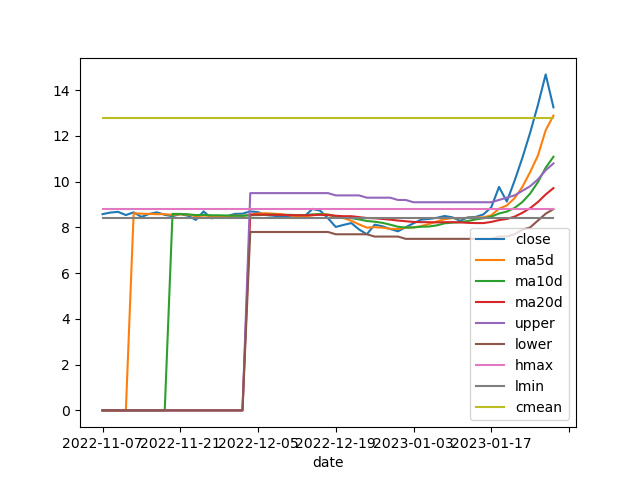

In [139]:
code
tdf = tdd.get_tdx_Exp_day_to_df(code, dl=60).sort_index(ascending=True)
# cname = tdd.get_sina_data_code(code)
# plt.title(
#     stock_code + " | " + cname + " | " + str(quotes.index[-1])[: 10],
#     fontsize=14)
tdf.loc[:, ["close", "ma5d", "ma10d", "ma20d",
            "upper", "lower", "hmax", 'lmin', 'cmean']].plot()

In [55]:
tdf[tdf.columns[(tdf.columns >= "perc1d") & (tdf.columns <= "perc9d")]][-1:]

,perc1d,perc2d,perc3d,perc4d,perc5d,perc6d,perc7d,perc8d,perc9d
date,,,,,,,,,
2023-02-02,1.1,1.1,1.1,1.1,1.0,1.0,1.1,1.1,1.1


In [63]:
tdf[tdf.columns[(tdf.columns >= "per1d") & (tdf.columns <= "per9d")]][-1:]

,per1d,per2d,per3d,per4d,per5d,per6d,per7d,per8d,per9d
date,,,,,,,,,
2023-02-02,10.0,10.0,10.0,10.0,10.0,-6.6,10.0,3.6,1.3
